##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [84]:
#%pip install pandas 
#%pip install matplotlib
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [85]:
# Can have as many cells as you want for code
import pandas as pd
import numpy as np
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

In [86]:
df = pd.read_parquet(filepath)
#df.head().style

SECTION 1: DATA ANALYSIS 
--- 
Data preprocessing: 

We are processing our columns according to 4 segments: 

#### General information
-  ['race_desc','ctrycode_desc','clttype','stat_flag','cltsex_fix','age','years_with_company']


#### User loyalty 
- avg_cancel_rate
- consent_level

#### Recovery 
- Risk level, 
- flg_latest_being_lapse, 
- n_months_last_bought_products, 
- recency_lapse, 
- recency_cancell 
- flg_is_proposal, 
- flg_with_preauthorisation, 
- flg_is_returned_mail, 
- is_dependent_in_at_least_one_policy
- aggregated product columns 

#### Monetary
- Income:  Annual_income_encoded
- Living status: flg_is_rental_flat 
- Household: hh_size_est_encoded
- Unemployment status: is_housewise_retiree
- Identity: is_sg_pr and is_class_1_2


#### target column: 
- f_purchase_lh




## General Information

- Almost all columns have None 
- meaning of P,G,C for customer type -> personal, group and corporate? This could be correlated to e.g. household information, possibly if they purchase as a family

In [87]:
def clean_general_info(df):
    df1 = df.copy()

    # drop clntnum
    #df1 = df1.drop("clntnum", axis=1)

    # races: None in race_desc should be replaced as a value. Either unknown or others 
    df1['race_desc'] = df1['race_desc'].fillna("Others")

    # country: None should be replaced with Not Applicable 
    # Combine both Not applicable and unknown country code
    df1['ctrycode_desc'] = df1['ctrycode_desc'].fillna("Not Applicable")

    df1['ctrycode_desc'] = df1['ctrycode_desc'].apply(lambda x: x if x == 'Singapore' else 'Others')

    # min_occ_date: calculate the duration this customer has been with singlife 
    # convert to datetime
    df1['min_occ_date'] = pd.to_datetime(df1['min_occ_date'], errors='coerce')
    years_with_singlife = (pd.to_datetime('now') - df1['min_occ_date']).dt.days / 365.25
    mean_duration = years_with_singlife.median() 
    df1['years_with_company'] = years_with_singlife.fillna(mean_duration).astype(int)
    df1.drop('min_occ_date', axis=1, inplace=True)

    # cltdob_fix: calculate age
    df1['cltdob_fix'] = pd.to_datetime(df1['cltdob_fix'], errors='coerce')
    age_in_years = (pd.to_datetime('now') - df1['cltdob_fix']).dt.days / 365.25
    mean_age = age_in_years.mean()
    df1['age'] = age_in_years.fillna(mean_age).astype(int) # fill with mean age
    # dropping DOB column 
    df1.drop('cltdob_fix', axis=1, inplace=True)

    # None value in gender 
    df1['cltsex_fix'].unique()
    # None value in gender: only a few, so replace by default: male 
    df1['cltsex_fix'] = df1['cltsex_fix'].fillna('Male')

    return df1 
df2 = clean_general_info(df)
#df2.head().style

### Data visualisation for general information 

In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

In [89]:
# process target column f_purcahse_lh as 0 and 1 
df2['f_purchase_lh'] = df2['f_purchase_lh'].fillna(0)

In [90]:
def plot_stacked_bars(dataframe, title_, ylabel_, size_=(18, 10), rot_=0, legend_="upper right"):
    """
    Plot stacked bars with annotations
    """
    ax = dataframe.plot(
        kind="bar",
        stacked=True,
        figsize=size_,
        rot=rot_,
        title=title_
    )

    # Annotate bars
    annotate_stacked_bars(ax, textsize=10)
    # Rename legend
    plt.legend(["Never Purchase", "Purchased"], loc=legend_)
    # Labels
    plt.ylabel(ylabel_)
    plt.show()

def annotate_stacked_bars(ax, pad=0.99, colour="black", textsize=13):
    """
    Add value annotations to the bars
    """

    # Iterate over the plotted rectanges/bars
    for p in ax.patches:
        
        # Calculate annotation
        value = str(round(p.get_height()))
        # If value is 0 do not annotate
        if value == '0':
            continue
        ax.annotate(
            value,
            ((p.get_x()+ p.get_width()/2)*pad-0.1, (p.get_y()+p.get_height()/2)*pad),
            color=colour,
            size=textsize
        )

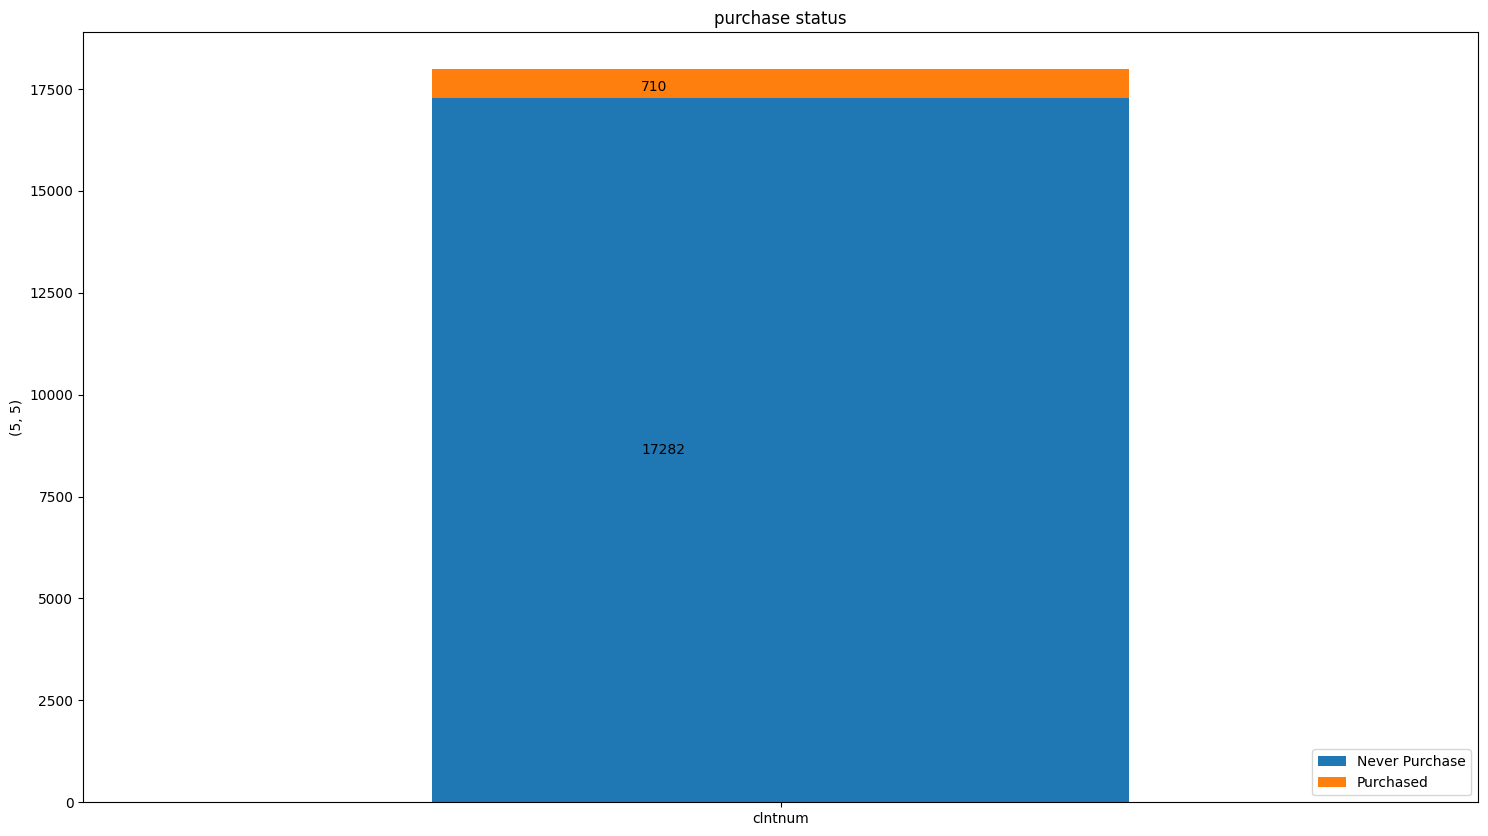

In [91]:
purchase = df2[['clntnum', 'f_purchase_lh']]
purchase_total = purchase.groupby(purchase['f_purchase_lh']).count()
purchase_percentage = purchase_total / purchase_total.sum() * 100
plot_stacked_bars(purchase_total.transpose(), "purchase status", (5, 5), legend_="lower right")

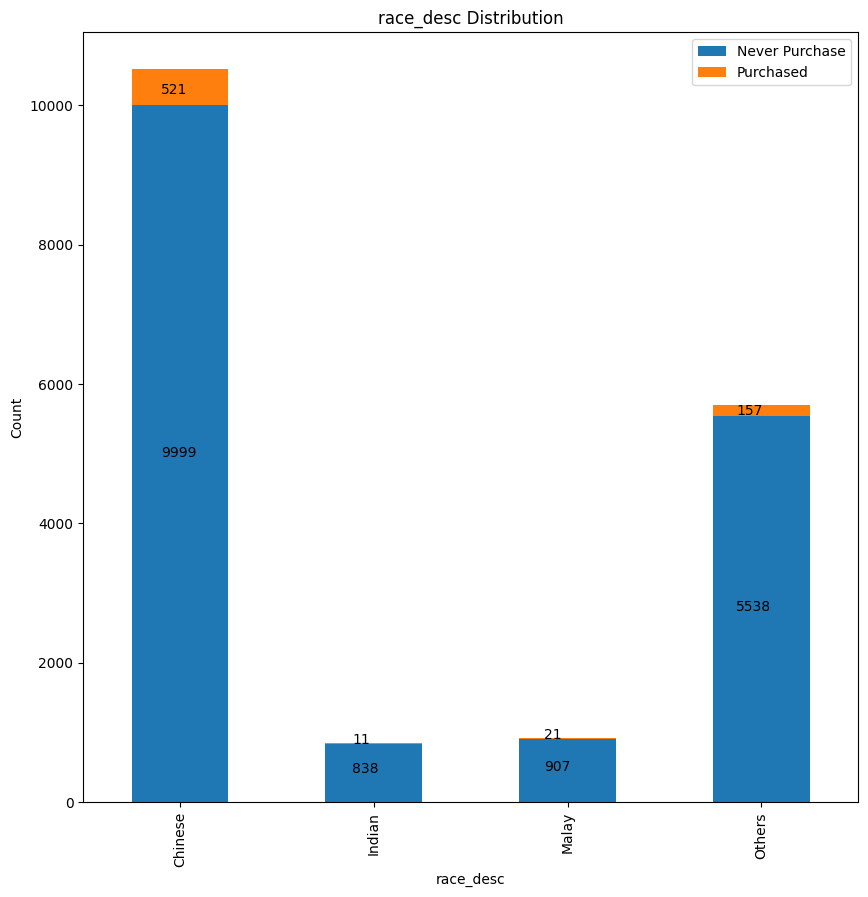

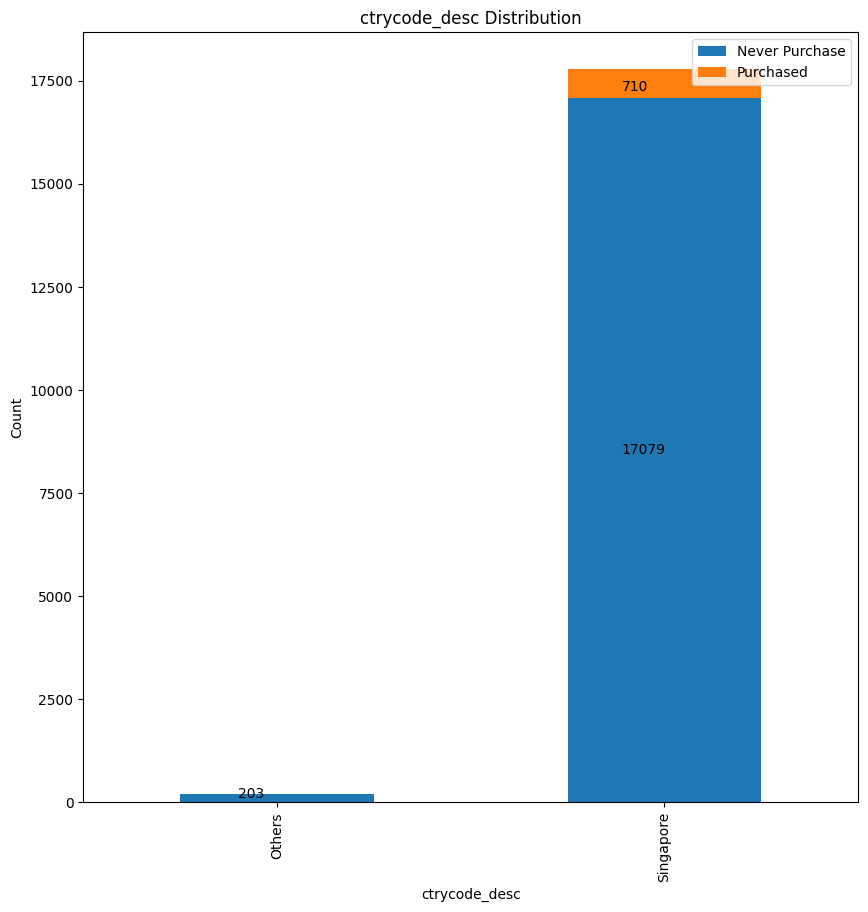

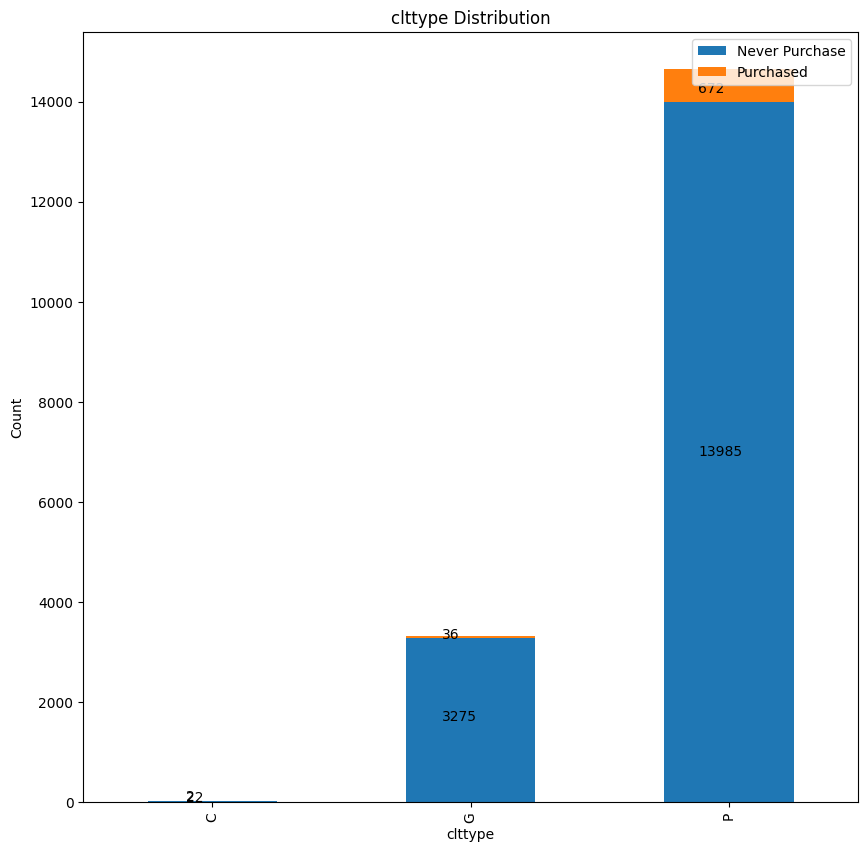

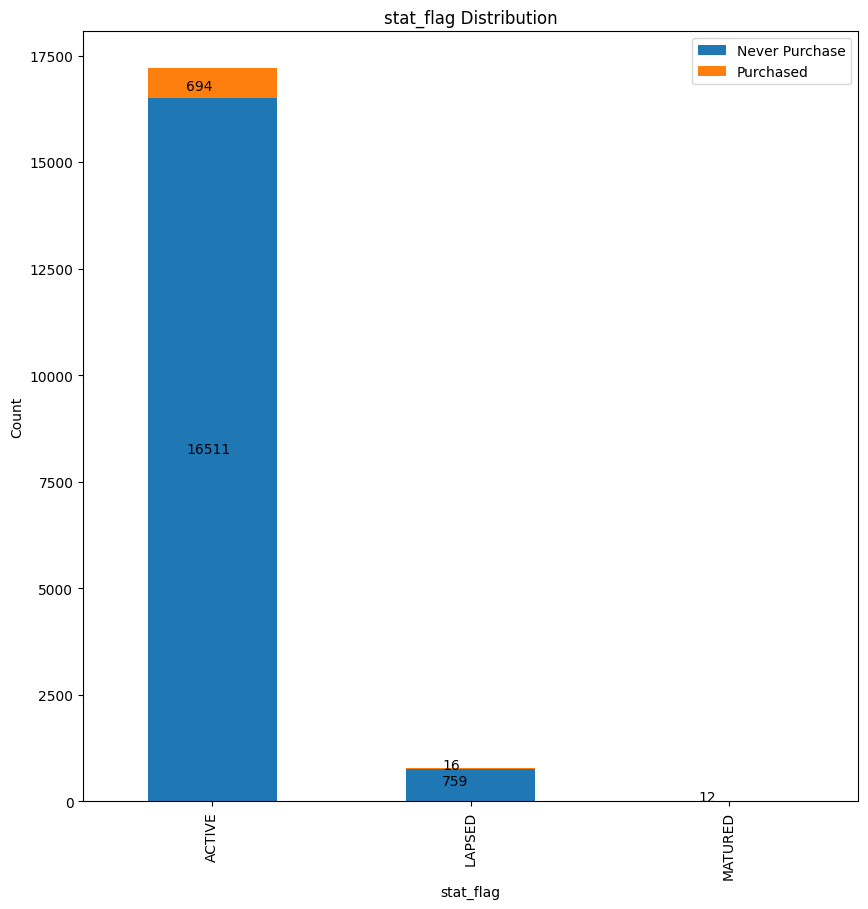

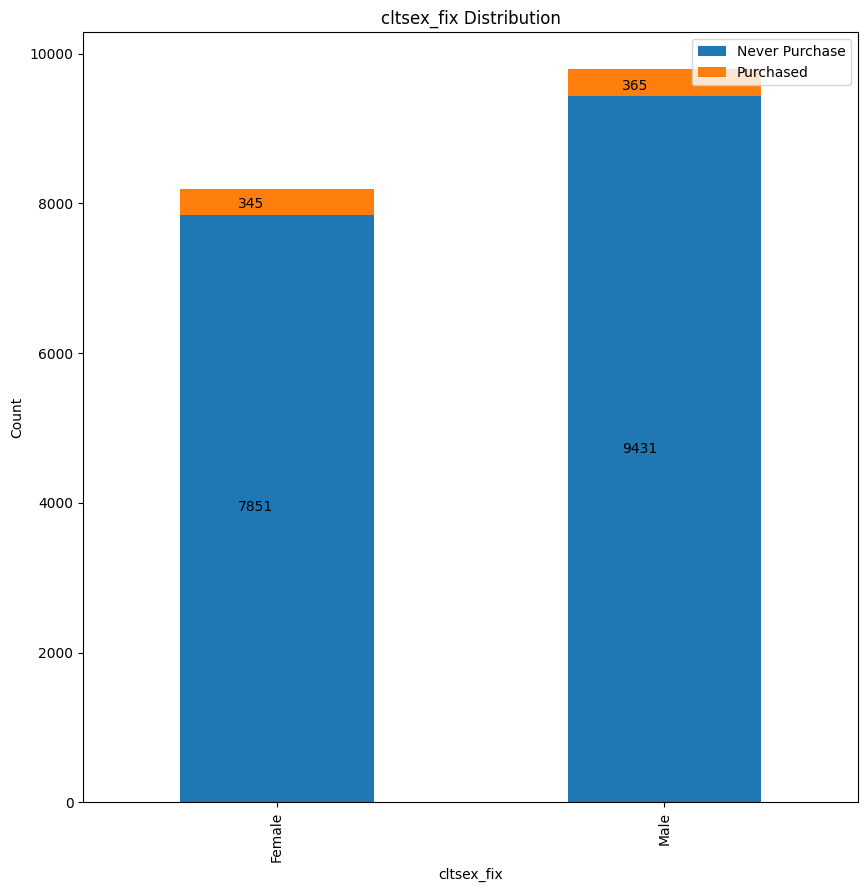

In [92]:
general_info_cat_col = ['race_desc','ctrycode_desc','clttype','stat_flag','cltsex_fix']
for col in general_info_cat_col:
    tb = pd.pivot_table(df2,index=col,values='clntnum', columns='f_purchase_lh',aggfunc='count',fill_value=0)
    plot_stacked_bars(tb, f"{col} Distribution", "Count",size_=(10, 10), rot_=90, legend_="upper right")

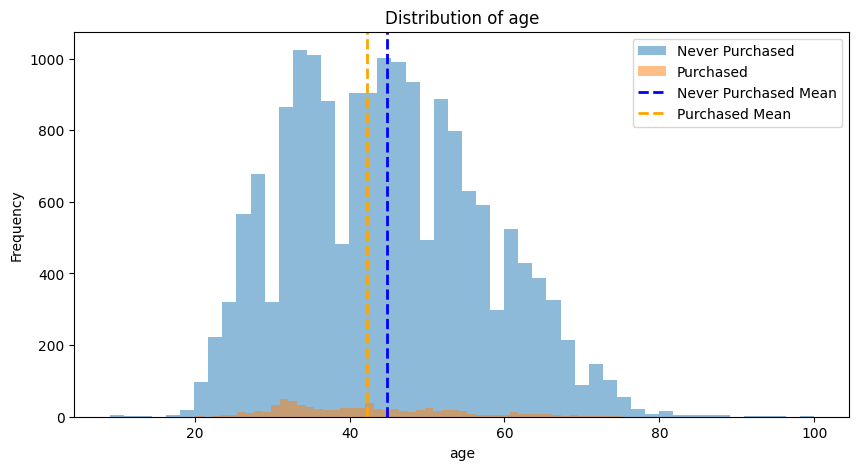

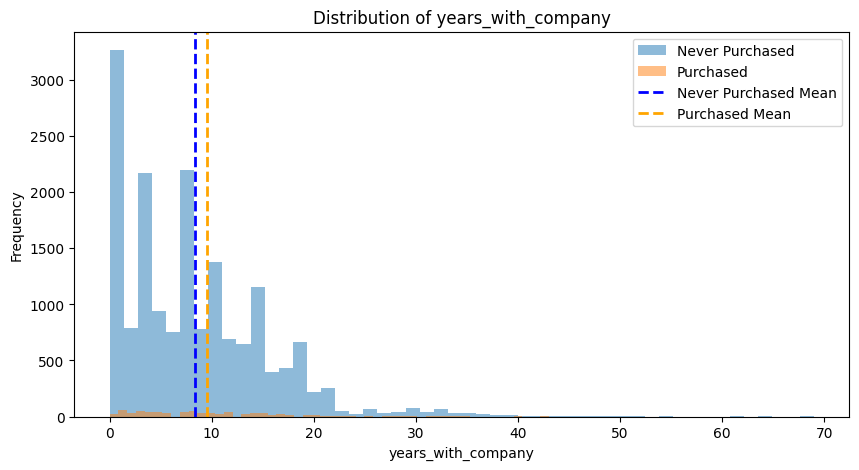

In [93]:
import matplotlib.pyplot as plt
import pandas as pd

general_info_num_col = ["age", "years_with_company"]

for col in general_info_num_col:
    fig, axs = plt.subplots(nrows=1, figsize=(10, 5))
    
    # Plot histogram
    df2[df2["f_purchase_lh"] == 0][col].plot(kind='hist', bins=50, ax=axs, alpha=0.5, label='Never Purchased')
    df2[df2["f_purchase_lh"] == 1][col].plot(kind='hist', bins=50, ax=axs, alpha=0.5, label='Purchased')
    
    #show the distribution mean for "Never Purchased"
    axs.axvline(df2[df2["f_purchase_lh"] == 0][col].mean(), color='blue', linestyle='dashed', linewidth=2, label='Never Purchased Mean')
    
    #show the distribution mean for "Purchased"
    axs.axvline(df2[df2["f_purchase_lh"] == 1][col].mean(), color='orange', linestyle='dashed', linewidth=2, label='Purchased Mean')
    
    axs.legend()

    axs.set_title(f'Distribution of {col}')
    axs.set_xlabel(col)
    axs.set_ylabel('Frequency')

plt.show()


Obvservation: 
1. Country code seem to be highly biased to Singapore, we will combine all other countries together and treat it as others 
2. Most people are with company for a few years, but we have outliers who are with outliers for more than 30 years. 
3. Age is follow normal distribution 

## Client Risk and Status Indicators
1. flg_substandard: Flag for substandard risk clients : client with higher than avg risk of loss 
2. flg_is_borderline_standard: Flag for borderline standard risk clients : in between standard risk and substandard risk 
3. flg_is_revised_term: Flag if customer ever has revised terms: adjustment made to the policy
4. flg_is_rental_flat: Indicates if the client lives in a rental flat : coule be related to household / useful for economic status 
5. flg_has_health_claim: Flag for clients with health insurance claims.
6. flg_has_life_claim: Flag for clients with life insurance claims.
7. flg_gi_claim: Flag for general insurance claims.
8. flg_is_proposal: Indicates if there is a policy in proposal for client: having a policy under review -> this could be quite important, as if the client is currently considering some policies, the probablity of purcashing could be higher 
9. flg_with_preauthorisation: Flag for clients with preauthorized transactions or policies: e.g. client have given permission for certain types of transcation, e.g. premium payment, 
10. flg_is_returned_mail: Flag for returned mail instances: the mail given is unresponse 

Some thoughts: 
- A few features can indicate whether the customer is actively responding(e.g. whether they already have an insurance, returned mail etc.), their economic status and their risk. Feature engineering could be along these lines 


In [94]:
def clean_up_risk_and_status(df):
    df1 = df.copy()
    # clean up float to int 
    columns_to_convert = ['flg_substandard', 'flg_is_borderline_standard', 'flg_is_revised_term',
       'flg_is_rental_flat', 'flg_has_health_claim', 'flg_has_life_claim',
       'flg_gi_claim', 'flg_is_proposal', 'flg_with_preauthorisation',
       'flg_is_returned_mail']
    for column in columns_to_convert:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)

    # New feature 1: has health / life / general insurance -> there is no need to distinguish them as the Qn ask for general purcahase too 

    # 1. Number of Insurance purchased
    df1['num_total_claims'] = (df1['flg_has_health_claim'] + df1['flg_has_life_claim'] + df1['flg_gi_claim']).fillna(0)

    # # 2. whether they purchased insurance (bought at least once)
    # df1['flg_health_or_life_claim'] = df1['flg_has_health_claim'] | df1['flg_has_life_claim'] | df1['flg_gi_claim']

    # 3. combine risk together: substandard risk -> level 3, boarderline -> level 2, standard -> level 1 
    conditions = [
        df1['flg_substandard'] == 1,
        df1['flg_is_borderline_standard'] == 1,
        ~(df1['flg_substandard'] == 1) & ~(df1['flg_is_borderline_standard'] == 1)  # Standard risk
    ]

    values = [3, 2, 1]

    # Create a new column 'risk_level' based on the conditions, if na means standard 
    df1['risk_level'] = np.select(conditions, values, default=1)

    # 4. dropping used columns 
    df1.drop(columns = ['flg_substandard','flg_is_borderline_standard','flg_has_health_claim','flg_has_life_claim','flg_gi_claim'],inplace=True)
    
    return df1


In [95]:
df2 = clean_up_risk_and_status(df2)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,recency_giclaim_unsuccess,flg_gi_claim_29d435_ever,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,risk_level
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,None,None,0.0,6,49,0,1
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,None,None,None,0.0,16,44,0,1
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,None,None,None,0.0,4,48,0,1
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,None,None,0.0,2,47,0,1
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,None,None,0.0,5,28,0,1


In [96]:
risk_related_col = ['risk_level']
active_related_col = ['flg_is_proposal','num_total_claims','flg_with_preauthorisation','flg_is_returned_mail']

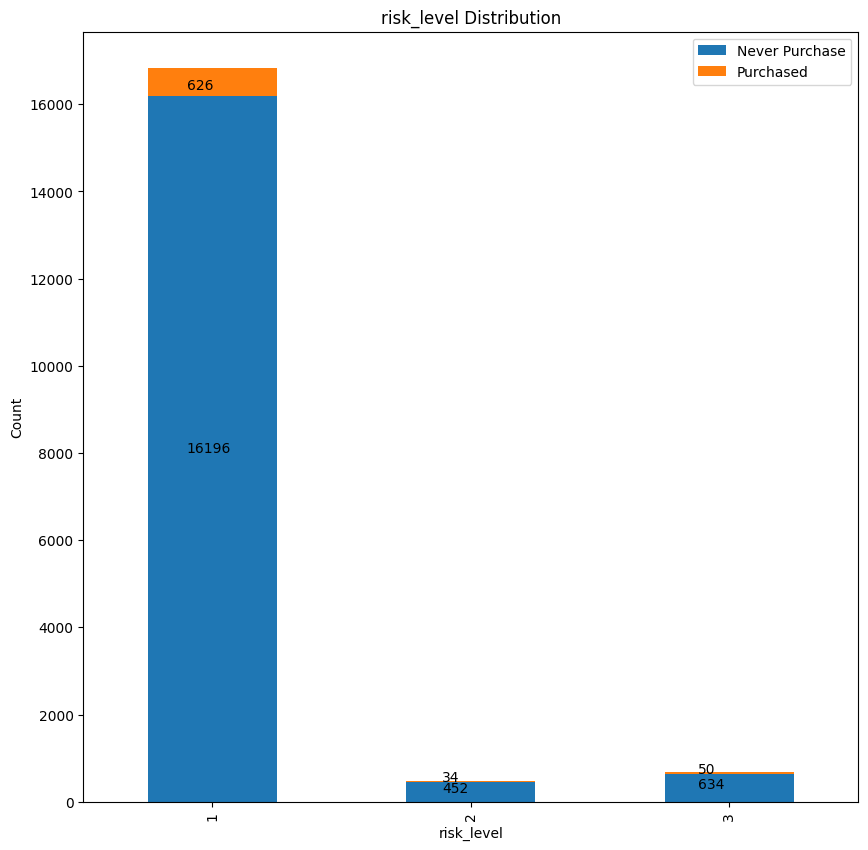

In [97]:
for col in risk_related_col:
    tb = pd.pivot_table(df2,index=col,values='clntnum', columns='f_purchase_lh',aggfunc='count',fill_value=0)
    plot_stacked_bars(tb, f"{col} Distribution", "Count",size_=(10, 10), rot_=90, legend_="upper right")

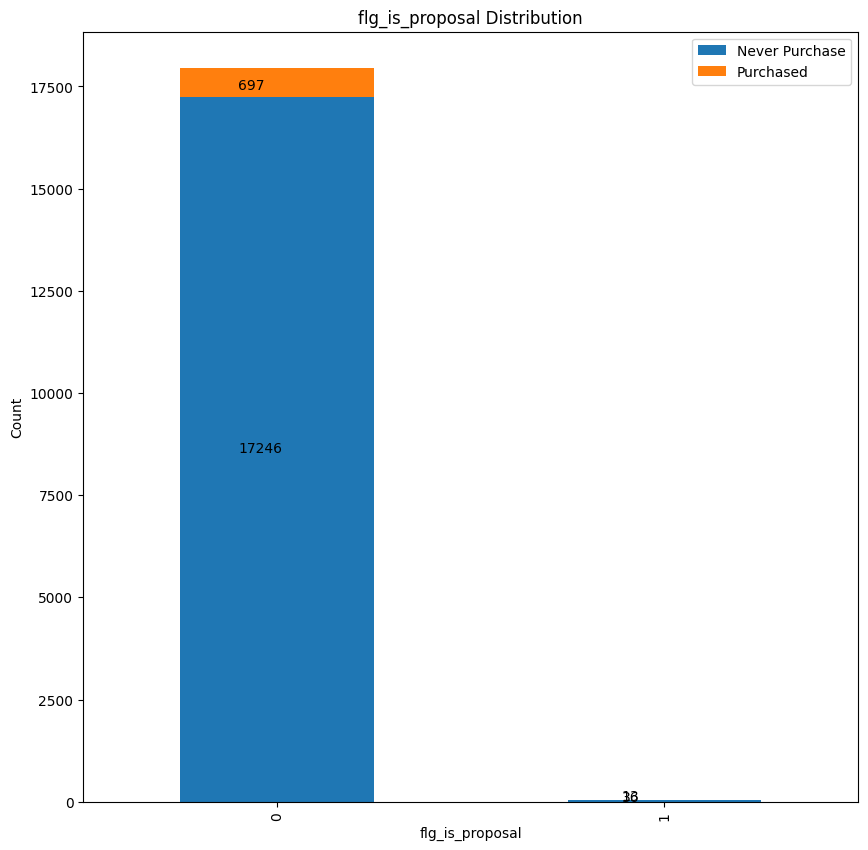

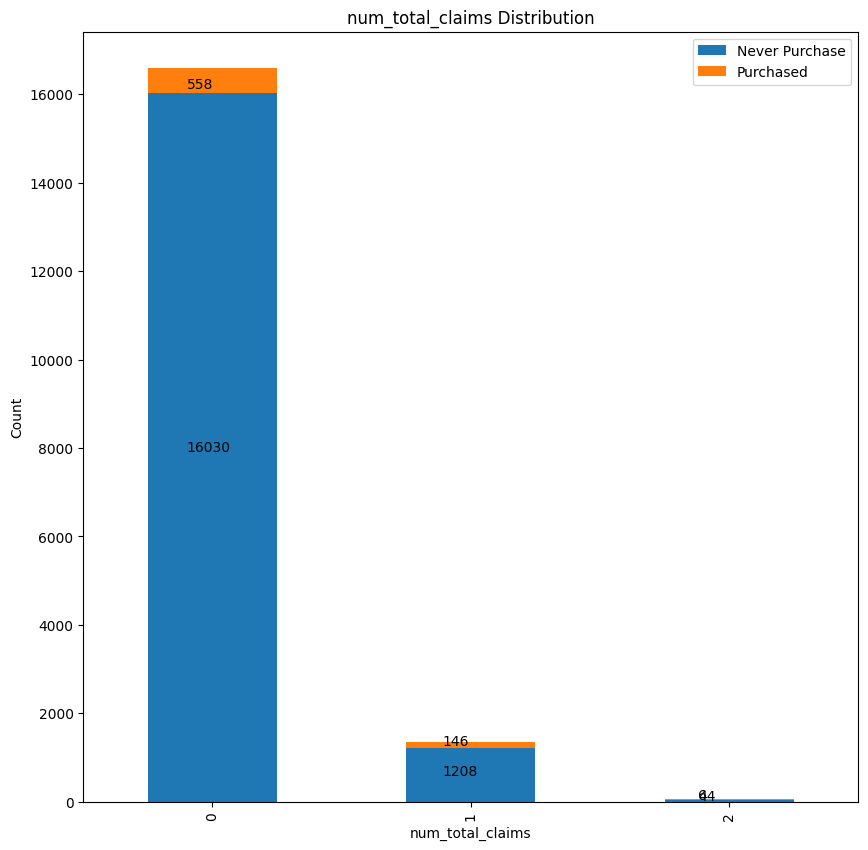

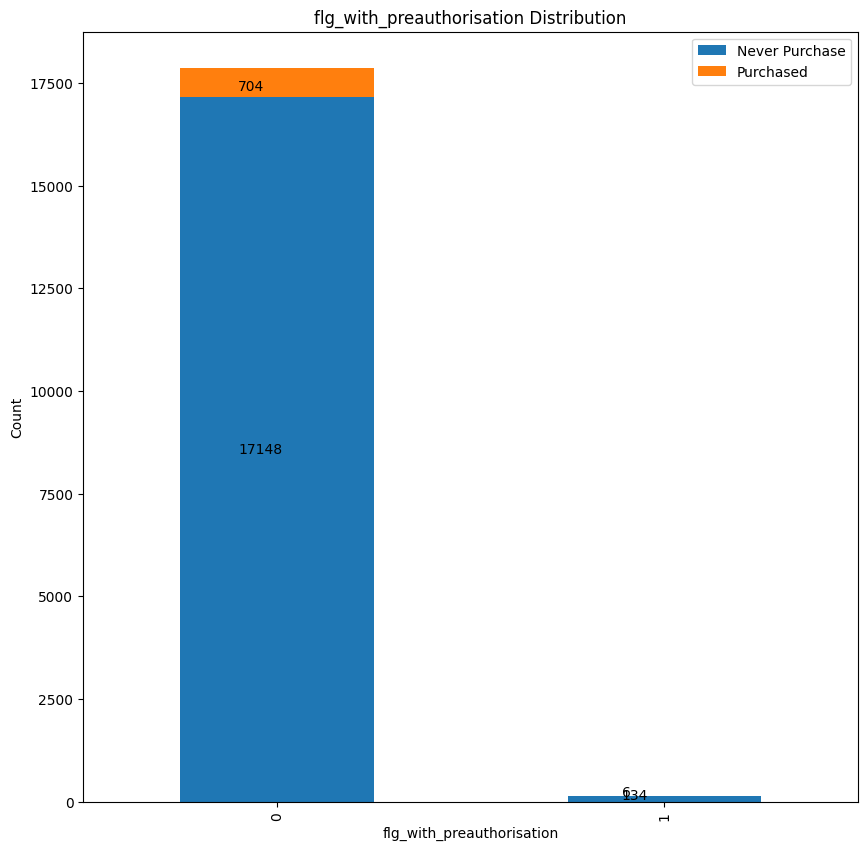

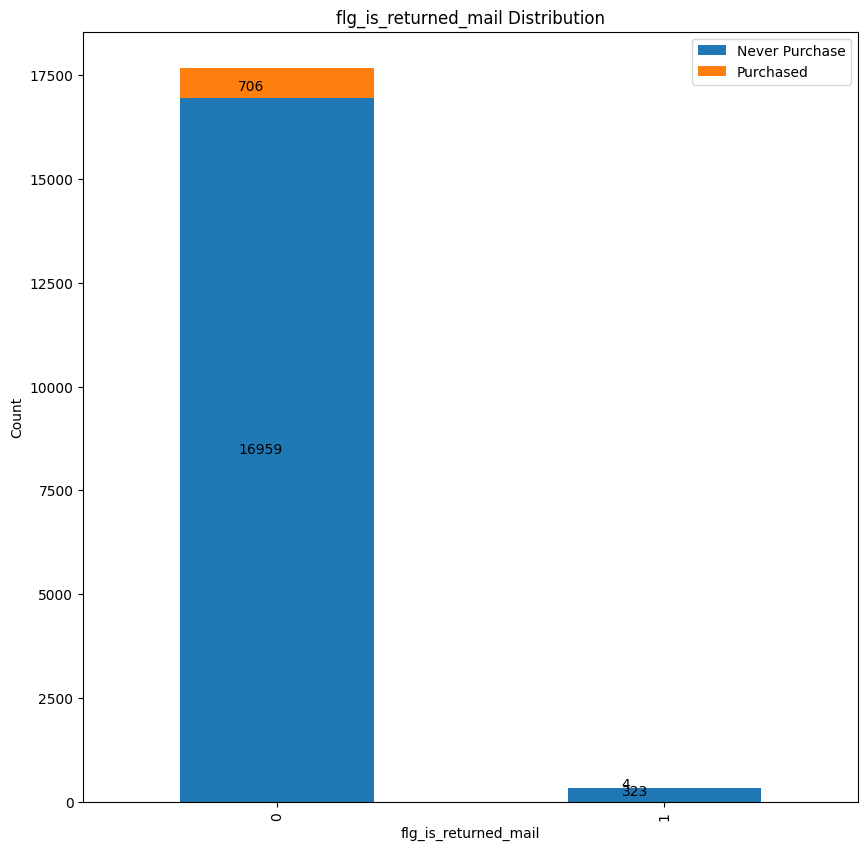

In [98]:
for col in active_related_col:
    tb = pd.pivot_table(df2,index=col,values='clntnum', columns='f_purchase_lh',aggfunc='count',fill_value=0)
    plot_stacked_bars(tb, f"{col} Distribution", "Count",size_=(10, 10), rot_=90, legend_="upper right")

## Demographic and Household Information
- pop_20 / hh_20 = hh_size 
- hh_size_set is a rounded value of hh_size 
- There is no need to keep all, and hh_size_est will be good enough 

In [99]:
def clean_up_household_info(df):

    df1 = df.copy()

    household_col = ['is_housewife_retiree', 'is_sg_pr', 'is_class_1_2',
       'is_dependent_in_at_least_1_policy', 'hh_20',
       'pop_20']
       
    for column in household_col:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)

    # annual income set 
    df1['annual_income_est'] = df1['annual_income_est'].fillna("F.UNKNOWN")
    income_mapping = {
        'F.UNKNOWN': 1,
        'E.BELOW30K': 2,
        'D.30K-60K': 3,
        'C.60K-100K': 4,
        'B.100K-200K': 5,
        'A.ABOVE200K': 6
    }

    # Apply ordinal encoding
    df1['annual_income_encoded'] = df1['annual_income_est'].map(income_mapping)

    # hh_size_est: level 0 to level 5  
    df1['hh_size_est'] = df1['hh_size_est'].fillna("0")
    hh_size_mapping = {
        '1': 1,
        '2': 2,
        '3': 3,
        '4': 4,
        '>4': 5,
        '0': 0
    }

    # Apply ordinal encoding
    df1['hh_size_est_encoded'] = df1['hh_size_est'].map(hh_size_mapping)

    # dropping columns 
    df1.drop(columns=['hh_20','pop_20','hh_size','hh_size_est','annual_income_est'],inplace=True)

    return df1

In [100]:
df2 = clean_up_household_info(df2)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,flg_gi_claim_058815_ever,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,risk_level,annual_income_encoded,hh_size_est_encoded
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,0.0,6,49,0,1,4,1
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,None,0.0,16,44,0,1,3,3
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,None,0.0,4,48,0,1,6,3
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,0.0,2,47,0,1,5,4
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,None,0.0,5,28,0,1,2,5


## Client Consent and Communication 
- Assuming consent to call indicate higher level of activeness 
- consent to email and mail, but the email address is invalid, is equivalent to not consent to email or mail 
- use is_valid_email and is_valid_mail to change is_consent_to_mail and is_consent_to_email
- combine the consent columns into 1: level 3 if consent to call, level 1 if consent to others, sum up the consent level 

In [101]:
def clean_consent(df):
    df1 = df.copy()
    consent_col = ['is_consent_to_mail', 'is_consent_to_email', 'is_consent_to_call',
        'is_consent_to_sms', 'is_valid_dm', 'is_valid_email']
    for column in consent_col:
        df1[column] = df1[column].fillna(0).astype(float).astype(int) # na can just assume they don't consent 

    conditions = [
        (df1['is_consent_to_call'] == 1),
        (df1['is_consent_to_email'] == 1) & (df1['is_valid_email'] == 1),
        (df1['is_consent_to_mail'] == 1) & (df1['is_valid_dm'] == 1),
        (df1['is_consent_to_sms'] == 1)
    ]

    # Define the corresponding consent levels
    values = [5, 1, 1, 1]

    # Create the 'consent_level' column by summing the values based on the conditions
    df1['consent_level'] = np.sum(np.column_stack(conditions) * np.array(values), axis=1)

    # drop old consent columns 
    df1.drop(columns=['is_consent_to_mail','is_consent_to_email','is_consent_to_call','is_consent_to_sms','is_valid_dm','is_valid_email'],inplace=True)

    return df1

In [102]:
df2 = clean_consent(df2)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,flg_gi_claim_42e115_ever,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,risk_level,annual_income_encoded,hh_size_est_encoded,consent_level
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,0.0,6,49,0,1,4,1,0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,0.0,16,44,0,1,3,3,0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,None,0.0,4,48,0,1,6,3,2
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,0.0,2,47,0,1,5,4,0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,None,0.0,5,28,0,1,2,5,3


## Policy and Claim History
- recency lapse: possibly referring to latest time since insurance holder failed to pay 
- recency lapse: possibly referring to latest time since insurance holder cancelled a their insurance
- total inforce policies -> policies that are still effective 
- latest being ...  -> whether the latest one they purchase has been lapsed / cancelled  

In [103]:
def clean_policy(df):
    df1 = df.copy()
    # should replace nan with 0 
    df1['f_ever_declined_la'] = df1['f_ever_declined_la'].fillna(0)

    # if nan, assume no cancellation / lapse happened, set recency_xxx to be 9999 
    df1["recency_lapse"] = df1["recency_lapse"].fillna(0)
    df1["recency_cancel"] = df1["recency_cancel"].fillna(0)


    # compute avg cancel rate 
    df1['avg_cancel_rate'] = (df1['tot_cancel_pols'] / (df1['tot_cancel_pols'] + df1['tot_inforce_pols'])).fillna(0)

    df1['f_ever_declined_la'] = df1['f_ever_declined_la'].fillna(0)


    df1 = df1.drop(columns=['flg_latest_being_lapse', 'flg_latest_being_cancel'], axis=1)
    return df1

In [104]:
df2 = clean_policy(df2)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,flg_gi_claim_856320_ever,f_purchase_lh,years_with_company,age,num_total_claims,risk_level,annual_income_encoded,hh_size_est_encoded,consent_level,avg_cancel_rate
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,6,49,0,1,4,1,0,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,0.0,16,44,0,1,3,3,0,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,None,0.0,4,48,0,1,6,3,2,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,2,47,0,1,5,4,0,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,None,0.0,5,28,0,1,2,5,3,0.0


# Purchase History
We would like to draw insights from the purchase history of a customer. 

- Columns __['Average_Bought_Gap']__ represents the average gap for a customer to buy any insurance product. 
- Additional columns __['Exceed Average Gap']__ & __['Exceed Average Gap with Purchase']__ calculate whether the months passed of last insurance purchase exceed the average purchase gap of a customer from current records. If TRUE, meaning the months passed exceeds the average gap. This shows it is more likely that certain customer will purchase a new insurance product soon. __['Exceed Average Gap']__ includes all customer with or without purchase while __['Exceed Average Gap with Purchase']__ only includes customers with past purchase history with the company.

- __['Claimed_Large_Amount']__ is created to study whether a customer has made any large amount claim in the past. If so, meaning this customer was once benefited from insurance and learnt the importance of insurance, who would more likely to purchase another insurance. The threshold value is set to $50,000 which is the whole thousands value slightly above median. 

- Similarly, new columns __['Lapsed_Large_Amount']__, __['Average_Lapse_Gap']__ are created for Lapse raw data.

- New column __['Months_Last_Bought_Category']__ created is to divide __['n_months_last_bought_products']__ column into different categories as the original column may not follow a simple linear relationship with the target column. We follow the generally used time curve to categorize them.

In [105]:
def clean_others(df): 
    df1 = df.copy()
    last_bought_months = df1.filter(regex='n_months_last_bought_.*', axis=1).columns

    for column in last_bought_months:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)


    df1[last_bought_months] = df1[last_bought_months].replace(9999, 0)

    df1['n_months_last_bought_products'] = df1['n_months_last_bought_products'].fillna(0)

    df1['Combined_List_Bought'] = df1[last_bought_months].apply(lambda row: sorted([val for val in row.tolist() if val != 0]), axis=1)
    df1['Bought_Gap_List'] = df1['Combined_List_Bought'].apply(lambda sorted_list: [b - a for a, b in zip(sorted_list[:-1], sorted_list[1:])])
    df1['Average_Bought_Gap'] = df1['Bought_Gap_List'].apply(lambda gaps: np.mean(gaps) if gaps else 0)

    df1['Average_Bought_Gap'][df1['Average_Bought_Gap'] !=0]

    df1['Exceed Average Gap'] = df1['Average_Bought_Gap'] <= df1['n_months_last_bought_products']
    sum(df1['Exceed Average Gap'])

    df1['Exceed Average Gap with Purchase'] = (df1['Average_Bought_Gap'] <= df1['n_months_last_bought_products']) & (df1['Average_Bought_Gap'] != 0)
    sum(df1['Exceed Average Gap with Purchase'])

    df1['Average_Bought_Gap'][df1['Average_Bought_Gap']>=36]

    bins = [-float('inf'), 3, 6, 12, 24, 36, 60, 120, float('inf')]
    labels = ['<3 months', '3-6 months', '6 months - 1 year', '1-2 years', '2-3 years', '3-5 years', '5-10 years', '> 10 years']

    df1['Months_Last_Bought_Category'] = pd.cut(df1['n_months_last_bought_products'], bins=bins, labels=labels)

    df1['Months_Last_Bought_Category']

    column_patterns = ['ape_', 'sumins_', 'prempaid_']
    regex_pattern = '^(' + '|'.join(column_patterns) + ')'
    claimed_amount = df1.filter(regex=regex_pattern, axis=1).columns

    df1['Claimed_Large_Amount'] = df1[claimed_amount].ge(50000).any(axis=1)
    sum(df1['Claimed_Large_Amount'])

    column_patterns = ['lapse_']
    regex_pattern = '^(' + '|'.join(column_patterns) + ')'
    lapsed_amount = df1.filter(regex=regex_pattern, axis=1).columns

    df1['Lapsed_Large_Amount'] = df1[lapsed_amount].ge(200).any(axis=1)
    sum(df1['Lapsed_Large_Amount'])

    last_lapse_months =  df1.filter(regex='n_months_since_lapse.*', axis=1).columns


    #df1[last_lapse_months] = df1[last_lapse_months].replace('9999', 0)
    for column in last_lapse_months:
        df1[column] = df1[column].fillna(0).astype(float).astype(int)


    df1[last_lapse_months] = df1[last_lapse_months].replace(9999, 0)


    df1['Combined_List_Lapse'] = df1[last_lapse_months].apply(lambda row: sorted([val for val in row.tolist() if val != 0]), axis=1)
    df1['Lapse_Gap_List'] = df1['Combined_List_Lapse'].apply(lambda sorted_list: [b - a for a, b in zip(sorted_list[:-1], sorted_list[1:])])
    df1['Average_Lapse_Gap'] = df1['Lapse_Gap_List'].apply(lambda gaps: np.mean(gaps) if gaps else 0)

    columns_to_drop = []

    column_patterns = ['f_ever_bought']
    regex_pattern = '^(' + '|'.join(column_patterns) + ')'
    ever_bought = df1.filter(regex=regex_pattern, axis=1).columns

    columns_to_drop.extend(last_bought_months)
    columns_to_drop.extend(claimed_amount)
    columns_to_drop.extend(last_lapse_months)
    columns_to_drop.extend(lapsed_amount)
    columns_to_drop.extend(ever_bought)
    columns_to_drop.extend(['Combined_List_Lapse','Lapse_Gap_List','Combined_List_Bought', 'Bought_Gap_List'])
    df1.drop(columns=columns_to_drop, inplace=True)


    return df1
    


In [106]:
df2 = clean_others(df2)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,hh_size_est_encoded,consent_level,avg_cancel_rate,Average_Bought_Gap,Exceed Average Gap,Exceed Average Gap with Purchase,Months_Last_Bought_Category,Claimed_Large_Amount,Lapsed_Large_Amount,Average_Lapse_Gap
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,1,0,0.0,1.25,False,False,<3 months,False,False,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,3,0,0.0,47.50,False,False,3-5 years,False,True,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,3,2,0.0,0.00,True,False,3-5 years,False,False,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,4,0,0.0,0.00,True,False,1-2 years,False,False,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,5,3,0.0,0.00,True,False,5-10 years,True,False,0.0


In [107]:
def f_hold_columns(df):
    df1 = df.copy()
    f_hold_columns = df1.filter(regex='f_hold_.*').columns

    for col in f_hold_columns:
        df1[col] = df1[col].astype(int)

    df1["f_hold"] = df1[f_hold_columns].sum(axis=1)
    df1.drop(columns=f_hold_columns, inplace=True)
    return df1 


In [108]:
df2 = f_hold_columns(df2)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,consent_level,avg_cancel_rate,Average_Bought_Gap,Exceed Average Gap,Exceed Average Gap with Purchase,Months_Last_Bought_Category,Claimed_Large_Amount,Lapsed_Large_Amount,Average_Lapse_Gap,f_hold
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0,0.0,1.25,False,False,<3 months,False,False,0.0,2
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,0,0.0,47.50,False,False,3-5 years,False,True,0.0,0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,2,0.0,0.00,True,False,3-5 years,False,False,0.0,0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0,0.0,0.00,True,False,1-2 years,False,False,0.0,0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,3,0.0,0.00,True,False,5-10 years,True,False,0.0,1


In [109]:
def hlthclaim(df):
    df1 = df.copy()
    pattern = r'flg_(hlthclaim|gi_claim)_[a-z0-9]+_ever'
    filtered_cols = df.filter(regex=pattern).columns

    #print(filtered_cols)

    df1[filtered_cols] = df1[filtered_cols].fillna(0)
    df1['flg_hlthclaim_ever'] = df1[filtered_cols].sum(axis=1)

    df1.drop(columns=filtered_cols, inplace=True)
    return df1


In [110]:
df2 = hlthclaim(df2)
df2.head()

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,cltsex_fix,flg_is_revised_term,flg_is_rental_flat,flg_is_proposal,flg_with_preauthorisation,...,avg_cancel_rate,Average_Bought_Gap,Exceed Average Gap,Exceed Average Gap with Purchase,Months_Last_Bought_Category,Claimed_Large_Amount,Lapsed_Large_Amount,Average_Lapse_Gap,f_hold,flg_hlthclaim_ever
19550,91b546e924,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0.0,1.25,False,False,<3 months,False,False,0.0,2,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,Male,0,0,0,0,...,0.0,47.50,False,False,3-5 years,False,True,0.0,0,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,Male,0,0,0,0,...,0.0,0.00,True,False,3-5 years,False,False,0.0,0,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0.0,0.00,True,False,1-2 years,False,False,0.0,0,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,Female,0,0,0,0,...,0.0,0.00,True,False,5-10 years,True,False,0.0,1,0.0


In [111]:
# print(df1.shape)
# df1.head().style

## Anonymized Insurance Product Metrics (APE, Sum Insured, Prepaid Premiums)
- Since we are only interested in whether the user will purchase an insurance -> we can reduce the data granularity to only insurance level in general 
- We realise the result is better without these 3 columns, and hence decide not to use them

In [112]:
def sum_and_drop_columns(df, prefix, new_column_name):
    filtered_columns = df.filter(regex=f'^{prefix}', axis=1)
    sumins_columns = filtered_columns.columns
    df[new_column_name] = filtered_columns.sum(axis=1)
    df.drop(columns=sumins_columns, inplace=True)

# ape 
# sum_and_drop_columns(df1, 'ape', 'total_ape_purchased')
# sumins 
# sum_and_drop_columns(df1, 'sumins', 'total_sumins_purchased')
# prempad 
# sum_and_drop_columns(df1, 'prempaid', 'total_prempaid_purchased')

In [113]:
#pip install catboost

In [114]:
# Delete Unique Client ID
df2 = df2.drop("clntnum", axis=1)

## Model Training

In [115]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.metrics import f1_score
import joblib

df = df2
col_to_target = ['f_purchase_lh']
for col in col_to_target:
    df[col] = df[col].fillna(0)

# Separate features and target
X = df.drop('f_purchase_lh', axis=1)
y = df['f_purchase_lh']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# Create a preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_cols),
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), categorical_cols)
    ])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with preprocessing, SMOTE, and CatBoost Classifier
model = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', CatBoostClassifier(random_state=42, verbose=0))
])

# Define the hyperparameter grid for CatBoost
param_grid = {
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__depth': [3, 5, 7],
    'classifier__iterations': [50, 100, 200],
    'classifier__subsample': [0.8, 0.9, 1.0],
    'classifier__colsample_bylevel': [0.8, 0.9, 1.0],
}

# Use Grid Search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluation
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred)
print("F1 Score: ", f1)

Best Hyperparameters: {'classifier__colsample_bylevel': 1.0, 'classifier__depth': 7, 'classifier__iterations': 200, 'classifier__learning_rate': 0.01, 'classifier__subsample': 0.8}
[[3343  105]
 [ 105   46]]
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97      3448
         1.0       0.30      0.30      0.30       151

    accuracy                           0.94      3599
   macro avg       0.64      0.64      0.64      3599
weighted avg       0.94      0.94      0.94      3599

F1 Score:  0.304635761589404


['model_pipeline.pkl']

## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [116]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    result = [] 
    df2 = clean_general_info(hidden_data)
    df2 = clean_up_risk_and_status(df2)
    df2 = clean_up_household_info(df2)
    df2 = clean_consent(df2)
    df2 = clean_policy(df2)
    df2 = clean_others(df2)
    df2 = f_hold_columns(df2)
    df2 = hlthclaim(df2)
    y_pred = best_model.predict(df2)
    result = y_pred.tolist()
    result = [np.nan if x == 0 else x for x in result]
    
    return result

##### Cell to check testing_hidden_data function

In [117]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 1.0, nan, nan, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,

### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!